In [49]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from individual import Tree
import protectedOperators

In [50]:
NUM_ISLANDS = 5
ISLAND_SIZE = 100
GENERATIONS = 1000
MAX_DEPTH = 13
MUTATION_RATE = 0.3
TOURNAMENT_SIZE = 3
MIGRATION_INTERVAL = 250
MIGRATION_SIZE = 2
PRINT_INTERVAL = 200
TREE_ATTEMPTS = 10
TEST_TRAIN = 0.8

In [ ]:
def plot_fitness_trend(fitness_history):
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, linestyle='-', color='blue', linewidth=2, label='Best Fitness')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Evolution Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

def plot_predictions(y_test, y_pred, fitness):
    sorted_idx = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[sorted_idx]
    y_pred_sorted = np.array(y_pred)[sorted_idx]
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_sorted, label="Truth", color="red", linewidth=2)
    plt.plot(y_pred_sorted, label="Prediction", color="blue", linewidth=1)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"Actual vs Predicted - Fitness: {fitness:.4f}")
    plt.legend()
    plt.grid()
    plt.show()

In [52]:
class SymbolicRegressionGP:
    def __init__(self, x_train, y_train,
                 num_islands=NUM_ISLANDS, island_size=ISLAND_SIZE, generations=GENERATIONS,
                 max_depth=MAX_DEPTH, mutation_rate=MUTATION_RATE, tournament_size=TOURNAMENT_SIZE,
                 migration_interval=MIGRATION_INTERVAL, migration_size=MIGRATION_SIZE,
                 print_interval=PRINT_INTERVAL, tree_attempts=TREE_ATTEMPTS):
        self.x_train = x_train
        self.y_train = y_train
        self.num_islands = num_islands
        self.island_size = island_size
        self.generations = generations
        self.max_depth = max_depth
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.migration_interval = migration_interval
        self.migration_size = migration_size
        self.print_interval = print_interval
        self.tree_attempts = tree_attempts
        self.populations = []

    def initialize_population(self):
        self.populations = []
        for _ in range(self.num_islands):
            island = []
            while len(island) < self.island_size:
                t = Tree(self.max_depth, self.x_train, self.y_train, self.tree_attempts)
                t.populate()
                if np.isfinite(t.fitness):
                    island.append(t)
            self.populations.append(island)

    def tournament_selection(self, population):
        tournament_size = min(self.tournament_size, len(population))
        participants = random.sample(population, tournament_size)
        participants.sort(key=lambda t: t.fitness)
        weights = [tournament_size - i for i in range(tournament_size)]
        return random.choices(participants, weights=weights, k=1)[0]

    def migrate(self):
        for i in range(self.num_islands):
            source = self.populations[i]
            target_index = (i + 1) % self.num_islands
            target = self.populations[target_index]
            migrants = sorted(source, key=lambda t: t.fitness)[:self.migration_size]
            target_sorted = sorted(target, key=lambda t: t.fitness, reverse=True)
            for j in range(self.migration_size):
                if migrants[j].fitness < target_sorted[j].fitness:
                    idx = target.index(target_sorted[j])
                    target[idx] = migrants[j].clone_tree()
            self.populations[target_index] = target

    def run(self):
        self.initialize_population()
        best_tree = None
        best_fitness = np.inf
        fitness_history = []
        for gen in tqdm(range(self.generations), desc="Generations"):
            for idx in range(self.num_islands):
                current_pop = self.populations[idx]
                new_pop = []
                elite = min(current_pop, key=lambda t: t.fitness)
                new_pop.append(elite.clone_tree())
                while len(new_pop) < self.island_size:
                    if random.random() < self.mutation_rate:
                        parent = self.tournament_selection(current_pop)
                        child = parent.clone_tree()
                        child.mutate()
                        new_pop.append(child)
                    else:
                        p1 = self.tournament_selection(current_pop)
                        p2 = self.tournament_selection(current_pop)
                        c1, c2 = p1.recombine(p2)
                        new_pop.extend([c1, c2])
                self.populations[idx] = sorted(current_pop + new_pop, key=lambda t: t.fitness)[:self.island_size]

            if (gen + 1) % self.migration_interval == 0:
                self.migrate()

            for pop in self.populations:
                best_island = min(pop, key=lambda t: t.fitness)
                if best_island.fitness < best_fitness:
                    best_fitness = best_island.fitness
                    best_tree = best_island.clone_tree()

            fitness_history.append(best_fitness)
            if (gen + 1) % self.print_interval == 0:
                print(f"Gen {gen+1} Best fitness: {best_fitness} Formula: {best_tree}")

        return best_tree, fitness_history

In [ ]:
def run_sym_reg_gp(problem_num):
    problem = np.load(f'./data/problem_{problem_num}.npz')
    x_data, y_data = problem['x'], problem['y']
    perm = np.random.permutation(len(y_data))
    x_data = x_data[:, perm]
    y_data = y_data[perm]

    train_size = int(TEST_TRAIN * len(y_data))
    x_train, y_train = x_data[:, :train_size], y_data[:train_size]
    x_test, y_test = x_data[:, train_size:], y_data[train_size:]

    gp = SymbolicRegressionGP(x_train, y_train)
    print(f"\nProblem {problem_num}")
    best_tree, history = gp.run()

    test_tree = best_tree.clone_tree()
    test_tree.x_train = x_test
    test_tree.y_train = y_test
    y_pred = test_tree.compute_fitness(True)

    print("Best Formula:", best_tree)
    print("Train fitness:", best_tree.fitness)
    print("Test fitness:", test_tree.fitness)

    best_tree.plot()
    plot_fitness_trend(history)
    plot_predictions(y_test, y_pred, test_tree.fitness)


Problem 2


Generations:  20%|██        | 200/1000 [01:09<06:03,  2.20it/s]

Gen 200 Best fitness: 8134094132616.59 Formula: multiply(absolute(subtract(protected_divide(protected_mod(protected_divide(protected_mod(cos(protected_divide(protected_divide(x[0], cos(square(1.2299826582611861))), x[0])), 2.718281828459045), negative(protected_power(add(2.718281828459045, sin(maximum(1.7320508075688772, x[0]))), -7.429610932521682))), 2.718281828459045), negative(protected_power(add(2.718281828459045, sin(maximum(1.7320508075688772, x[0]))), -7.429610932521682))), add(negative(protected_divide(2.718281828459045, negative(protected_power(add(2.718281828459045, sin(maximum(1.7320508075688772, x[0]))), -7.429610932521682)))), protected_divide(square(minimum(absolute(maximum(x[1], square(protected_mod(minimum(1.7320508075688772, sinh(-7.429610932521682)), arctan(x[2]))))), protected_log(protected_power(subtract(-7.429610932521682, add(x[0], add(x[1], 2.718281828459045))), negative(minimum(protected_power(add(2.718281828459045, 2.718281828459045), -7.429610932521682), tan(

Generations:  40%|████      | 400/1000 [03:34<08:25,  1.19it/s]

Gen 400 Best fitness: 1516220012780.6458 Formula: multiply(absolute(subtract(protected_divide(protected_mod(minimum(0.0, protected_log(protected_power(subtract(add(x[0], add(x[1], x[2])), add(sin(maximum(1.7320508075688772, x[0])), add(2.718281828459045, 1.7320508075688772))), absolute(add(2.718281828459045, 1.7320508075688772))))), 2.718281828459045), negative(protected_power(add(2.718281828459045, absolute(cbrt(1.7320508075688772))), -7.429610932521682))), add(negative(protected_divide(3.141592653589793, negative(protected_power(add(2.718281828459045, sin(maximum(1.7320508075688772, x[0]))), -7.429610932521682)))), protected_divide(square(minimum(cos(square(negative(-7.429610932521682))), protected_log(protected_power(subtract(add(add(x[1], x[2]), x[0]), add(2.718281828459045, add(2.718281828459045, 1.7320508075688772))), negative(-7.429610932521682))))), protected_log(absolute(cbrt(absolute(cbrt(absolute(cbrt(1.4142135623730951))))))))))), add(maximum(protected_divide(x[0], cos(squa

Generations:  60%|██████    | 600/1000 [07:18<07:47,  1.17s/it]

Gen 600 Best fitness: 1039077563484.2189 Formula: multiply(absolute(subtract(protected_divide(protected_mod(minimum(0.0, protected_log(protected_power(subtract(add(x[0], add(x[1], x[2])), add(sin(maximum(2.718281828459045, x[0])), add(2.718281828459045, cbrt(2.718281828459045)))), minimum(add(1.7320508075688772, protected_mod(1.7320508075688772, exp(protected_sqrt(3.141592653589793)))), maximum(add(2.718281828459045, 2.718281828459045), sin(protected_power(minimum(x[0], x[0]), x[1]))))))), 2.718281828459045), negative(protected_power(add(2.718281828459045, 1.2299826582611861), -7.429610932521682))), add(negative(protected_divide(3.141592653589793, negative(protected_power(add(2.718281828459045, sin(maximum(1.7320508075688772, x[0]))), -7.429610932521682)))), protected_divide(square(minimum(add(2.718281828459045, 2.718281828459045), protected_log(protected_power(subtract(add(x[0], add(x[1], x[2])), add(2.718281828459045, add(2.718281828459045, 1.7320508075688772))), add(add(add(x[2], x[

Generations:  80%|████████  | 800/1000 [11:15<03:37,  1.09s/it]

Gen 800 Best fitness: 908135048764.4883 Formula: multiply(absolute(subtract(protected_divide(protected_mod(minimum(0.0, protected_log(protected_power(subtract(add(add(x[1], x[2]), x[0]), add(sin(maximum(2.718281828459045, x[0])), add(2.718281828459045, cbrt(2.718281828459045)))), minimum(add(2.718281828459045, protected_mod(exp(protected_sqrt(3.141592653589793)), 1.7320508075688772)), maximum(add(x[0], add(2.718281828459045, 2.718281828459045)), sin(protected_power(minimum(x[0], x[0]), x[1]))))))), 2.718281828459045), negative(protected_power(add(1.2299826582611861, 2.718281828459045), -7.429610932521682))), add(protected_divide(square(minimum(maximum(protected_divide(add(add(x[1], x[2]), protected_sqrt(add(x[1], square(2.718281828459045)))), subtract(add(x[0], add(x[2], x[1])), add(2.718281828459045, add(2.718281828459045, multiply(x[0], 1.2299826582611861))))), x[0]), protected_log(protected_power(subtract(add(add(x[1], x[2]), x[0]), add(2.718281828459045, add(2.718281828459045, 1.73

Generations: 100%|██████████| 1000/1000 [15:27<00:00,  1.08it/s]

Gen 1000 Best fitness: 772904698253.6763 Formula: multiply(absolute(subtract(protected_divide(protected_mod(minimum(0.0, protected_log(protected_power(subtract(add(add(x[1], x[2]), x[0]), add(sin(maximum(2.718281828459045, x[0])), add(2.718281828459045, cbrt(2.718281828459045)))), minimum(add(2.718281828459045, protected_mod(exp(protected_sqrt(3.141592653589793)), 1.7320508075688772)), maximum(add(x[0], 2.718281828459045), sin(protected_power(x[0], x[1]))))))), 2.718281828459045), negative(protected_power(add(1.2299826582611861, 2.718281828459045), -7.429610932521682))), add(protected_divide(square(minimum(maximum(protected_divide(add(add(x[1], x[2]), protected_sqrt(add(x[2], x[2]))), subtract(add(x[0], add(x[2], x[1])), add(2.718281828459045, add(2.718281828459045, multiply(x[0], 1.2299826582611861))))), x[0]), protected_log(protected_power(subtract(add(add(x[1], x[2]), x[0]), add(add(2.718281828459045, 1.7320508075688772), 2.718281828459045)), add(add(x[1], 2.718281828459045), add(2.

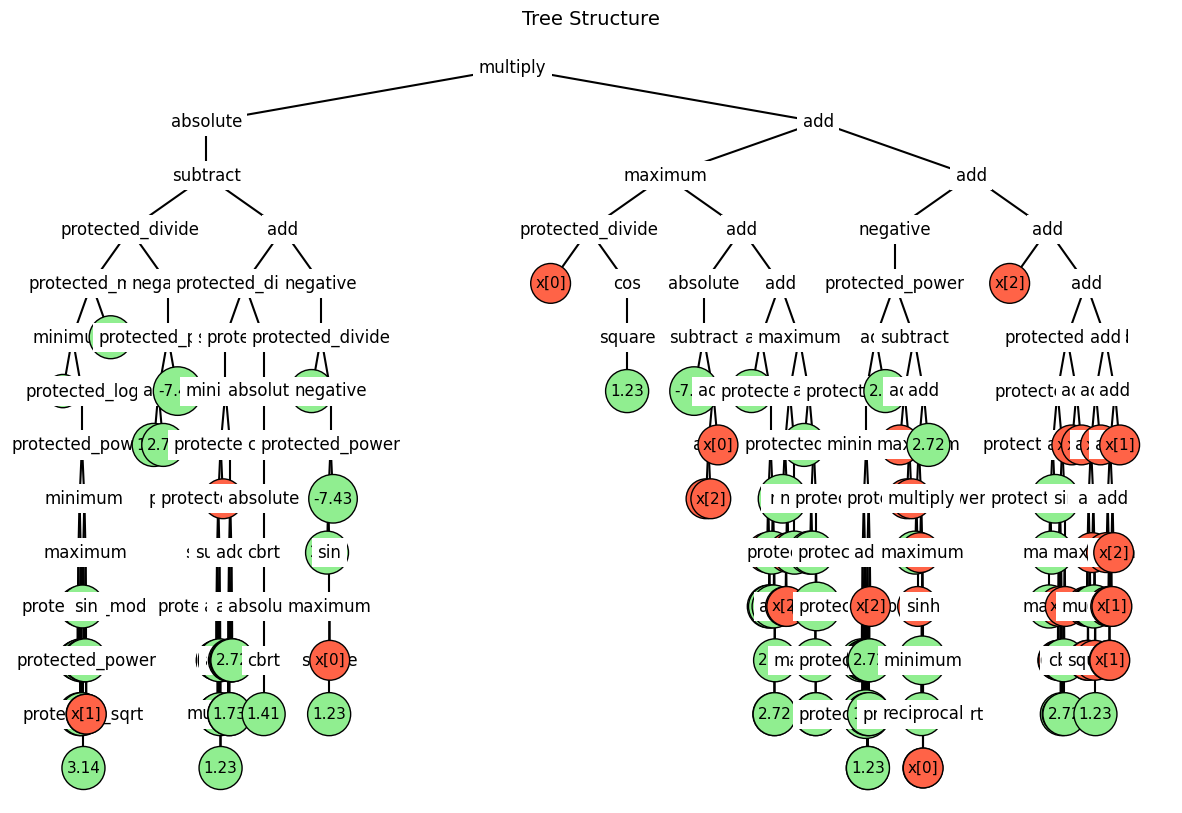

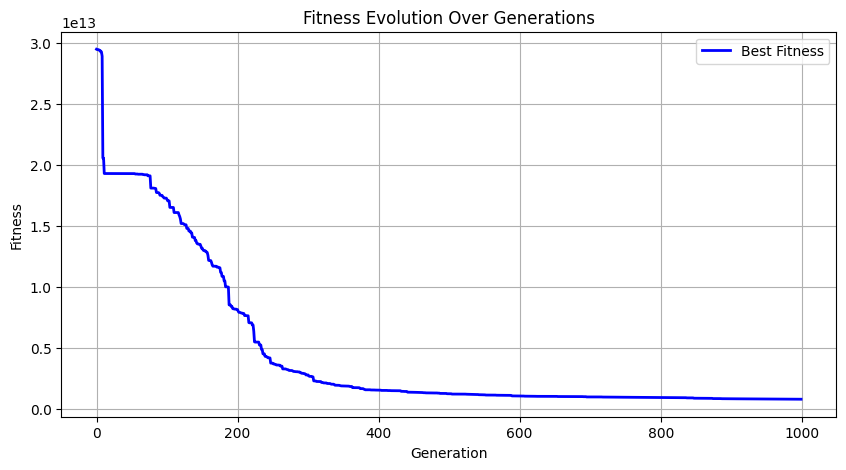

TypeError: unsupported format string passed to numpy.ndarray.__format__

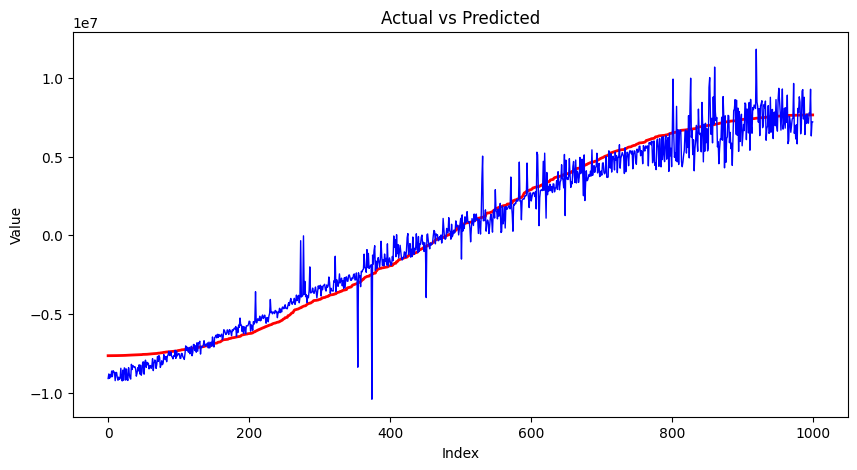

In [54]:
np.seterr(all='ignore')
run_sym_reg_gp(2)